# Portfolio Optimization

In [1]:
import pandas as pd
import numpy as np
from sklearn.covariance import *
from typing import Callable
import math
from scipy.optimize import minimize
import inspect
import matplotlib.pyplot as plt

## Import data

In [2]:
df_raw_all = pd.read_hdf("dow30_full_selected.h5")


In [3]:
df_raw_prices = df_raw_all[["date", "tic", "close"]].rename(columns={"close": "price"})


In [4]:
df_prices = df_raw_prices.pivot(index="date", columns="tic", values="price").loc[
    "2009-01-02":"2020-01-01"
]


## Generate returns from prices

In [5]:
class Returns:
    def __init__(self, price_data: pd.DataFrame):
        """
        Initializes the Returns class instance with asset price data

        Parameters
        ----------
        price_data : pd.DataFrame
            Price data of assets
        """
        self.price_matrix = price_data.values.T
        self.assets = price_data.columns
        self.index = price_data.index

    @staticmethod
    def return_formula(
        price_matrix: np.ndarray,
        index: pd.Index,
        roll: bool = True,
        window: int = 1,
        log: bool = False,
    ) -> tuple:
        """"
        Convert price data to return data

        Parameters
        ----------
        price_matrix : np.ndarray
            Matrix of prices
        index : pd.Index
            Dates time scale
        roll : bool, optional
            Rolling return, by default True
        int : int, optional
            Time interval, by default 1
        log : bool, optional
            Continuous or discrete, by default False

        Returns
        -------
        tuple
            Returns a tuple of (array of returns, dates)
        """
        step = 1 if roll else window
        shift = window

        return (
            (
                np.log(
                    ((price_matrix / np.roll(price_matrix, shift=shift, axis=1)) - 1)
                )[:, shift::step],
                index[shift::step],
            )
            if log
            else (
                ((price_matrix / np.roll(price_matrix, shift=shift, axis=1)) - 1)[
                    :, shift::step
                ],
                index[shift::step],
            )
        )

    def compute_returns(self, method: str, **kwargs) -> pd.DataFrame:
        """
        Calculates asset returns based on defined method and parameters

        Parameters
        ----------
        method: str
            Options = ["daily", "rolling", "collapse"]
            daily: calculates daily percentage change
            rolling: calculates rolling percentage change based on window, user passes in a parameter window=?
            collapse: calculates percentage change based on window, user passes in a parameter window=?
                e.g.: if window=22, output is the return between each 22 day interval from the beginning
            Aditional option: calculates continuous return by passing in log=True, or discrete otherwise
        **kwargs: arguments passed into return_formula()

        Returns
        -------
        pd.DataFrame
            Returns a pandas DataFrame of asset returns
        """
        price_matrix = self.price_matrix
        index = self.index

        if method == "daily":
            return_matrix, return_idx = Returns.return_formula(
                price_matrix, index, window=1, roll=True, **kwargs
            )
        elif method == "rolling":
            return_matrix, return_idx = Returns.return_formula(
                price_matrix, index, roll=True, **kwargs
            )
        elif method == "collapse":
            return_matrix, return_idx = Returns.return_formula(
                price_matrix, index, roll=False, **kwargs
            )
        else:
            print(
                "What is going on? Invalid method! Valid Inputs: daily, rolling, collapse"
            )

        return pd.DataFrame(return_matrix.T, columns=self.assets, index=return_idx)

    def compute_mean_return(
        self, method: str, time_scaling: int = 252, **kwargs
    ) -> pd.Series:
        """
        Calculates mean historical asset returns to be used in mean-variance optimizer

        Parameters
        ----------
        method: str
            Options = ["arithmetic", "geometric"]
            arithmetic: Calculates the arithmetic mean of return, all paramters in compute_returns() can be passed in as additional arguments
            geometric: Calculates the geometric mean from first to last observation

        time_scaling: int, optional
            Annualizes daily mean return, by default 252

        **kwargs: additional arguments if using arithmetic

        Returns
        -------
        pd.Series
            Returns a pandas Series of asset mean returns
        """
        price_matrix = self.price_matrix
        index = self.index

        return_matrix, return_idx = Returns.return_formula(
            price_matrix, index, **kwargs
        )

        if method == "arithmetic":
            mean_return = np.mean(return_matrix, axis=1) * time_scaling
        elif method == "geometric":
            mean_return = (
                (price_matrix[:, -1] / price_matrix[:, 0])
                ** (time_scaling / price_matrix.shape[1])
            ) - 1
        else:
            print(
                "What is going on? Invalid method! Valid Inputs: arithmetic, geometric"
            )

        return pd.Series(mean_return, index=self.assets)


## Compute covariance matrix

In [6]:
# TODO: higher order moments ?
class Risks:
    def __init__(self, returns_data: pd.DataFrame):
        """
        Initializes the Risks class instance with asset returns data

        Parameters
        ----------
        returns_data : pd.DataFrame
            Price data of assets
        """
        self.return_matrix = returns_data.values.T
        self.assets = returns_data.columns

    def semi_cov(
        self,
        return_matrix: np.ndarray,
        bm_return: float = 0.0001,
        assume_zero: bool = False,
    ) -> np.ndarray:
        """
        Computes the semi-covariance matrix

        Parameters
        ----------
        return_matrix : np.ndarray
            Array of returns
        bm_return : float, optional
            Ignores all individual asset returns above the bm_return when calculating covariance, by default 0.0001
        assume_zero : bool, optional
            Long term daily mean return for an individual asset is sometimes assumed to be 0, by default False

        Returns
        -------
        np.ndarray
            Matrix of returns to use in semi-covariance estimation
        """
        return_matrix_copy = return_matrix.copy()

        def adjust_return_vector(return_vector: np.ndarray, bm_return: float):
            return_vector[return_vector >= bm_return] = np.mean(
                return_vector[return_vector < bm_return]
            )

            return return_vector

        return_matrix_copy = (
            np.fmin(return_matrix_copy - bm_return, 0)
            if assume_zero
            else np.apply_along_axis(
                adjust_return_vector,
                axis=1,
                arr=return_matrix_copy,
                bm_return=bm_return,
            )
        )

        return return_matrix_copy

    def construct_weights(self, return_matrix: np.ndarray) -> np.ndarray:
        """
        Customized weight array

        Parameters
        ----------
        return_matrix : np.ndarray
            Array of returns

        Returns
        -------
        np.ndarray
            Returns array of weights for each asset (can be not all equal, in progress)
        """

        return np.repeat(
            np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]
        )

    @staticmethod
    def find_cov(
        return_matrix: np.ndarray, weight_factor: np.ndarray, builtin: bool
    ) -> np.ndarray:
        """
        Estimate a covariance matrix, given data and weights

        Parameters
        ----------
        return_matrix : np.ndarray
            Array of returns
        weight_factor : np.ndarray
            Array of observation vector weights. These relative weights are typically large for observations considered “important” and smaller for observations considered less “important”
        builtin : bool
            If True then calls np.cov() to calculate, otherwise use matrix calculation method written in the class

        Returns
        -------
        np.ndarray
            The covariance matrix of the asset returns
        """
        return np.cov(return_matrix, aweights=weight_factor)

    def sample_cov(
        self,
        return_matrix: np.ndarray,
        unit_time: int = 1,
        weights: np.ndarray = None,
        builtin: bool = False,
        **kwargs
    ) -> np.ndarray:
        """
        Sample covariance computation

        Parameters
        ----------
        return_matrix : np.ndarray
            Array of 
        unit_time : int
            Frequency of returns, by default 1 (daily)
        weights : np.ndarray, optional
            Array of observation weights, by default None
        builtin : bool, optional
            If True then calls np.cov() to calculate covariance, otherwise use matrix calculation method written in the class, by default False

        Returns
        -------
        np.ndarray
            Array of sample covariance values
        """
        weights = self.construct_weights(return_matrix)

        return Risks.find_cov(return_matrix, weights, builtin) * unit_time

    def scikit_cov_technique(
        self,
        return_matrix: np.ndarray,
        technique: str,
        time_scaling: int = 252,
        **kwargs
    ) -> np.ndarray:
        """
        Using sklearn.covariance methods to construct covariance matrix

        Parameters
        ----------
        return_matrix : np.ndarray
            Array of returns
        technique : str
            Options to select sklearn.covariance methods
        time_scaling : int, optional
            Annualize covariance matrix (assuming daily input), by default 252

        Returns
        -------
        np.ndarray
            Returns covariance matrix in it's raw form
        """
        technique_dict = {
            "EmpiricalCovariance": EmpiricalCovariance,
            "EllipticEnvelope": EllipticEnvelope,
            "GraphicalLasso": GraphicalLasso,
            "GraphicalLassoCV": GraphicalLassoCV,
            "LedoitWolf": LedoitWolf,
            "MinCovDet": MinCovDet,
            "OAS": OAS,
            "ShrunkCovariance": ShrunkCovariance,
        }

        try:
            return (
                technique_dict[technique](**kwargs).fit(return_matrix.T).covariance_
                * time_scaling
            )
        except KeyError:
            print(
                "What is going on? Invalid technique! Valid inputs: EmpiricalCovariance, EllipticEnvelope, GraphicalLasso, GraphicalLassoCV, LedoitWolf, MinCovDet, OAS, ShrunkCovariance"
            )

    def compute_cov_matrix(
        self,
        technique: str = "sample",
        semi: bool = False,
        time_scaling: int = 252,
        builtin: bool = False,
        weights: np.ndarray = None,
        bm_return: float = 0.00025,
        assume_zero: bool = False,
        normalize: bool = False,
        **kwargs
    ) -> pd.DataFrame:
        """
        Calculates covariance matrix given the return data input

        Parameters
        ----------
        technique : str, optional
            additional_options: ["EmpiricalCovariance", "EllipticEnvelope", "GraphicalLasso", "GraphicalLassoCV",
                                    "LedoitWolf", "MinCovDet", "OAS", "ShrunkCovariance"]
            Specifies the calculation technique for the covariance matrix, by default "sample"
        semi : bool, optional
            If True, returns a semivariance matrix that emphasizes on downside portfolio variance, by default False
        time_scaling : int, optional
            Default annualizes the covariance matrix (assuming daily return is the input), by default 252
        builtin : bool, optional
            If True then calls np.cov() to calculate, otherwise use matrix calculation method written in the class, by default False
        weights : np.ndarray, optional
            Array of observation vector weights, by default None
        bm_return : float, optional
            additional parameter for calculating semivariance matrix, by default 0.00025
        assume_zero : bool, optional
            Long term daily mean return for an individual asset is sometimes assumed to be 0, by default False
        normalize : bool, optional
            To normalize the covariance matrix. In the specific case for covariance matrix, a normalized covariance
            matrix is a correlation matrix, by default False

        Returns
        -------
        pd.DataFrame
            Returns the covariance matrix as a pandas DataFrame
        """
        return_matrix = self.return_matrix

        if semi:
            return_matrix = self.semi_cov(
                return_matrix, bm_return=bm_return, assume_zero=assume_zero
            )

        if technique == "sample":
            cov_matrix = self.sample_cov(
                return_matrix, time_scaling, builtin=builtin, weights=weights, **kwargs
            )
        else:
            cov_matrix = self.scikit_cov_technique(
                return_matrix, technique, time_scaling, **kwargs
            )

        if normalize:
            cov_mat = cov_mat * np.dot(
                ((np.diag(cov_mat)) ** -0.5).reshape(-1, 1),
                ((np.diag(cov_mat)) ** -0.5).reshape(1, -1),
            )

        return pd.DataFrame(cov_matrix, index=self.assets, columns=self.assets)


## Declare metrics, constraints and objectives

In [7]:
# TODO: add utility functions
class Metrics:
    def __init__(
        self,
        return_vector: np.ndarray,
        moment_matrix: np.ndarray,
        assets: list,
        moment: int = 2,
    ):
        """
        Initializes a Metrics instance with parameters to compute portfolio metrics

        Parameters
        ----------
        return_vector : np.ndarray
            Vector of mean returns
        moment_matrix : np.ndarray
            Covariance matrix
        assets : list[str]
            List of asset names
        moment : int, optional
            The order of moment matrix, by default 2
        """
        self.return_vector = return_vector
        self.moment_matrix = moment_matrix
        self.moment = moment
        self.assets = assets

        self.method_dict = {
            "leverage": self.leverage,
            "num_assets": self.num_assets,
            "concentration": self.concentration,
            "correlation": self.correlation,
            "diversification": self.diversification,
            "volatility": self.volatility,
            "risk_parity": self.risk_parity,
            "expected_return": self.expected_return,
            "sharpe": self.sharpe,
        }

    # Weight related portfolio metrics

    def leverage(self, w: np.ndarray) -> float:
        """
        Computes the leverage of the portfolio based on weights

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights

        Returns
        -------
        float
            Total leverage of portfolio
        """
        return np.sum(np.sqrt(np.square(w)))

    def num_assets(self, w: np.ndarray) -> int:
        """
        Computes the number of assets in the portfolio based on weights

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights

        Returns
        -------
        int
            Number of assets
        """
        return len(w[np.round(w, 4) != 0])

    def concentration(self, w: np.ndarray, top_holdings: int) -> float:
        """
        Computes the % concentration of the portfolio based on weights

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights
        top_holdings : int
            _description_

        Returns
        -------
        float
            The percentage of the portfolio formed by the top_holdings number of assets
        """
        return -np.sum(
            np.partition(-np.sqrt(np.square(w)), top_holdings)[:top_holdings]
        ) / np.sum(np.sqrt(np.square(w)))

    # Risk portfolio metrics

    def correlation(self, w: np.ndarray) -> float:
        """
        Computes the portfolio correlation coefficient based on weights

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights

        Returns
        -------
        float
            Correlation coefficient
        """
        corr_matrix = self.moment_matrix * np.dot(
            ((np.diag(self.moment_matrix)) ** -0.5).reshape(-1, 1),
            ((np.diag(self.moment_matrix)) ** -0.5).reshape(1, -1),
        )

        return w @ corr_matrix @ w.T

    def diversification(self, w: np.ndarray) -> float:
        """
        Computes the portfolio diversification based on weights

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights

        Returns
        -------
        float
            Ratio of the weighted average of volatilities divided by the portfolio volatility
        """
        std_arr = np.diag(self.moment_matrix) ** 0.5

        return (w @ std_arr) / np.sqrt(w @ self.moment_matrix @ w.T)

    def volatility(self, w: np.ndarray) -> float:
        """
        Computes the portfolio volatility based on weights

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights

        Returns
        -------
        float
            Standard deviation of portfolio returns
        """
        return np.sqrt(w @ self.moment_matrix @ w.T)

    def variance(self, w: np.ndarray) -> float:
        """
        Computes the portfolio variance based on weights

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights

        Returns
        -------
        float
            Variance of portfolio returns
        """
        return w @ self.moment_matrix @ w.T

    def risk_parity(self, w: np.ndarray) -> float:
        """
        Computes the portfolio risk-parity based on weights

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights

        Returns
        -------
        float
            Risk-parity of portfolio
        """
        return 0.5 * w @ self.moment_matrix @ w.T - np.sum(np.log(w)) / len(self.assets)

    # Risk-reward portfolio metrics

    def expected_return(self, w: np.ndarray) -> float:
        """
        Compute the portfolio expected return based on weights

        Parameters
        ----------
        w : np.ndarray
            

        Returns
        -------
        float
            _description_
        """
        return w @ self.return_vector

    def sharpe(self, w: np.ndarray, rfr: float = 0.04) -> float:
        """
        Calculates the Sharpe ratio of the portfolio
        *If the covariance matrix is semivariance matrix, then it calculates the Sortino ratio

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights
        rfr : float, optional
            Constant risk free rate of return, by default 0.04

        Returns
        -------
        float
            Sharpe ratio of portfolio
        """
        assert rfr > 0, "Risk free rate must be greater than 0."

        return (self.expected_return(w) - rfr) / self.volatility(w)

    # Constant portfolio weights

    def inverse_volatility(self, leverage: float) -> np.ndarray:
        """
        Weights of the portfolio are based on the inverse volatility of the individual assets

        Parameters
        ----------
        leverage : float
            Leverage coefficient

        Returns
        -------
        np.ndarray
            Array of portfolio weights
        """
        std_arr = np.diag(self.moment_matrix) ** 0.5

        return (1 / std_arr) / np.sum(1 / std_arr) * leverage

    def inverse_variance(self, leverage: float) -> np.ndarray:
        """
        Weights of the portfolio are based on the inverse variance of the individual assets

        Parameters
        ----------
        leverage : float
            Leverage coefficient

        Returns
        -------
        np.ndarray
            Array of portfolio weights
        """
        var_arr = np.diag(self.moment_matrix)

        return (1 / var_arr) / np.sum(1 / var_arr) * leverage

    def equal_weight(self, leverage: float) -> np.ndarray:
        """
        Equal weight portfolio

        Parameters
        ----------
        leverage : float
            Leverage coefficient

        Returns
        -------
        np.ndarray
            Array of portfolio weights
        """
        return np.repeat(leverage / len(self.assets), len(self.assets))



In [8]:
class Objective(Metrics):
    def __init__(
        self,
        return_vector: np.ndarray,
        moment_matrix: np.ndarray,
        assets: list,
        moment: int = 2,
    ):
        # Same parameters as Metrics()
        super().__init__(return_vector, moment_matrix, assets, moment)

        self.method_dict = {
            "quadratic_utility": self.efficient_frontier,
            "equal_risk_parity": self.equal_risk_parity,
            "min_correlation": self.min_correlation,
            "min_volatility": self.min_volatility,
            "min_variance": self.min_variance,
            "max_return": self.max_return,
            "max_diversification": self.max_diversification,
            "max_sharpe": self.max_sharpe,
            "inverse_volatility": self.inverse_volatility,
            "inverse_variance": self.inverse_variance,
            "equal_weight": self.equal_weight,
        }

    # Risk related objective functions

    def equal_risk_parity(self, w: np.ndarray) -> float:
        """
        Individual assets contribute equal amounts of risk to the portfolio

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights

        Returns
        -------
        float
            Risk parity global value
        """
        return self.risk_parity(w)

    def min_correlation(self, w: np.ndarray) -> float:
        """
        Minimize portfolio correlation factor

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights

        Returns
        -------
        float
            Correlation factor global value
        """
        return self.correlation(w)

    def min_volatility(self, w: np.ndarray) -> float:
        """
        Minimize portfolio volatility

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights

        Returns
        -------
        float
            Volatility global value
        """
        return self.volatility(w)

    def min_variance(self, w: np.ndarray) -> float:
        """
        Minimize portfolio variance

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights

        Returns
        -------
        float
            Variance global value
        """
        return self.variance(w)

    def max_diversification(self, w: np.ndarray) -> float:
        """
        Maximize portfolio diversification

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights

        Returns
        -------
        float
            Diversification factor global value
        """
        return -self.diversification(w)

    # Risk-reward related objective functions

    def efficient_frontier(self, w: np.ndarray, aversion: float) -> float:
        """
        Maximize return with lowest variance (quadratic utility)

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights
        aversion : float
            Risk aversion parameter

        Returns
        -------
        float
            Quadratic utility global value
        """
        return -(self.expected_return(w) - 0.5 * aversion * self.variance(w))

    def max_return(self, w: np.ndarray) -> float:
        """
        Maximize return regardless of risk

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights

        Returns
        -------
        float
            Return global value
        """
        return -self.expected_return(w)

    def max_sharpe(self, w: np.ndarray, rfr: float) -> float:
        """
        Maximize Sharpe ratio

        Parameters
        ----------
        w : np.ndarray
            Array of portfolio weights
        rfr : float
            Risk free rate of return

        Returns
        -------
        float
            Sharpe ratio global value
        """
        return -self.sharpe(w, rfr)

    def create_objective(self, objective_type: str, **kwargs) -> Callable:
        """
        Function to construct objective function

        Parameters
        ----------
        objective_type : str
            String to specify the type of objective function

        Returns
        -------
        function
            If weight function is not numerical (array of weights) return objective function
        """
        if objective_type in {"equal_weight", "inverse_volatility", "inverse_variance"}:
            return self.method_dict["objective_type"](**kwargs)
        else:
            return self.method_dict[objective_type]


In [9]:
# TODO: beta constaint, treynor, alpha
class Constraints(Metrics):
    def __init__(
        self,
        return_vector: np.ndarray,
        moment_matrix: np.ndarray,
        assets: list,
        moment: int = 2,
    ):
        # Same parameters as Metrics()
        super().__init__(return_vector, moment_matrix, assets, moment)

        self.method_dict = {
            "weight": self.weight_const,
            "num_assets": self.num_assets_const,
            "concentration": self.concentration_const,
            "expected_return": self.expected_return_const,
            "sharpe": self.sharpe_const,
            "volatility": self.volatility_const,
            "variance": self.moment_const,
        }

    @staticmethod
    def construct_weight_bound(
        size: int, init_bound: tuple, weight_bound: np.ndarray
    ) -> list:
        """
        Construct portfolio weight bounds

        Parameters
        ----------
        size : int
            Number of assets
        init_bound : tuple
            Initial bound (0,1)
        weight_bound : np.ndarray or tuple
            Predetermined constraints on individual weights

        Returns
        -------
        List[tuple]
            List of tuples of lower and upper bounds
        """
        individual_bound = init_bound

        if isinstance(weight_bound[0], (float, int)):
            individual_bound = list(
                zip(np.repeat(weight_bound[0], size), np.repeat(weight_bound[1], size))
            )
        elif isinstance(weight_bound, np.ndarray):
            if weight_bound.ndim == 1:
                individual_bound = list(
                    zip(
                        np.repeat(weight_bound[0], size),
                        np.repeat(weight_bound[1], size),
                    )
                )
            elif weight_bound.ndim == 2:
                individual_bound = list(zip(weight_bound[:, 0], weight_bound[:, 1]))

        return individual_bound

    @staticmethod
    def construct_const_bound(
        bound: float, minimum: bool, opposite_value: float
    ) -> tuple:
        """
        Construct constraint bound based on input

        Parameters
        ----------
        bound : float
            Bound value
        minimum : bool
            Indicate whether passed in bound is upper or lower
        opposite_value : float
            The opposite value of the bound

        Returns
        -------
        tuple
            Constraint bound
        """
        if isinstance(bound, (int, float)):
            print(
                f"Only one bound is given, will set the {'maximum' if minimum else 'minimum'} value to be {opposite_value}"
            )
            bound = (bound, opposite_value) if minimum else (opposite_value, bound)
        return bound

    @staticmethod
    def generate_random_weights(size: int, bound: list, leverage: float) -> np.ndarray:
        """
        Generate random portfolio weights

        Parameters
        ----------
        size : int
            Number of assets
        bound : list
            If bounds are identical for every single asset than use dirichilet distribution to generate random portfolios
            This has the advantage of creating highly concentrated/diversified portfolios that proxy real world portfolio allocations
            Note that bound constraints are perfectly adhered to if leverage=1 and setting an extremely high leverage value may cause violations on bound constraints
            If bounds are not identical then generate with normal distribution Note that randomness deteriorates with more assets
        leverage : float
            Total leverage

        Returns
        -------
        np.ndarray
            Array of random weights
        """
        if all(bound[0][0] == low for low, high in bound) and all(
            bound[0][1] == high for low, high in bound
        ):
            rand_weight = np.random.dirichlet(np.arange(1, size + 1))
            if bound[0][0] < 0:
                neg_idx = np.random.choice(
                    rand_weight.shape[0], np.random.choice(size + 1), replace=False
                )
                rand_weight[neg_idx] = -rand_weight[neg_idx]
                temp = rand_weight * (bound[0][1] - bound[0][0]) / 2 + (
                    bound[0][0] + (bound[0][1] - bound[0][0]) / 2
                )
            else:
                temp = rand_weight * (bound[0][1] - bound[0][0]) + bound[0][0]
        else:
            temp = np.zeros(shape=size)
            for idx, interval in enumerate(bound):
                val = np.random.randn(1)[0]
                std = (interval[1] - interval[0]) / 2
                mu = (interval[1] + interval[0]) / 2
                temp[idx] = val * std + mu

        temp = temp / np.abs(temp).sum() * leverage  # Two Standard Deviation
        return temp

    def create_constraint(self, constraint_type: str, **kwargs) -> Callable:
        """
        Universal method for creating a constraint

        Parameters
        ----------
        constraint_type : str
            Constraint type, options are in Constraints.method_dict
        **kwargs: arguments to be passed to construct constraints

        Returns
        -------
        Callable
            Constraint function
        """
        return self.method_dict[constraint_type](**kwargs)

    # Portfolio composition constraints

    def weight_const(self, weight_bound: np.ndarray, leverage: float) -> tuple:
        """
        Construction of individual portfolio weight bound and total leverage

        Parameters
        ----------
        weight_bound : np.ndarray
            Specify each indivual asset's weight bound or weight for all assets
        leverage : float
            The total leverage constraint for the portfolio

        Returns
        -------
        tuple
            Individual bound and total leverage for the portfolio
        """
        init_bound = (0, 1)

        individual_bound = Constraints.construct_weight_bound(
            self.return_vector.shape[0], init_bound, weight_bound
        )

        total_leverage = [{"type": "eq", "fun": lambda w: -self.leverage(w) + leverage}]

        return individual_bound, total_leverage

    def num_assets_const(self, num_assets: int) -> list:
        """
        Constraint on the number of assets that can be held

        Parameters
        ----------
        num_assets : int
            Maximum number of assets

        Returns
        -------
        list
            Dictionnary to specify the type of constraint and the callable constraint         
        """
        if self.return_vector.shape[0] <= num_assets:
            print(
                "What is going on? The number of assets to hold exceeds the number of assets available, default to a 1 asset only scenario."
            )
            num_assets = self.return_vector.shape[0] - 1
        non_holdings = self.return_vector.shape[0] - num_assets

        return [
            {
                "type": "eq",
                "fun": lambda w: np.sum(
                    np.partition(np.sqrt(np.square(w)), non_holdings)[:non_holdings]
                ),
            }
        ]

    def concentration_const(self, top_holdings: int, top_concentration: float) -> list:
        """
        Constraint on the concentration of the portfolio in the most heavily weighted assets

        Parameters
        ----------
        top_holdings : int
            Number of top holdings to compute concentration
        top_concentration : float
            Maximum % concentration of the top holdings

        Returns
        -------
        list
            Dictionnary to specify the type of constraint and the callable constraint
        """
        if self.return_vector.shape[0] <= top_holdings:
            print(
                "What is going on? Number of top holdings exceeds total available assets. Will default top_holdings to be number of holdings available."
            )
            top_holdings = self.return_vector.shape[0]

        return [
            {
                "type": "ineq",
                "fun": lambda w: np.sum(
                    np.partition(-np.sqrt(np.square(w)), top_holdings)[:top_holdings]
                )
                / np.sum(np.sqrt(np.square(w)))
                + top_concentration,
            }
        ]

    # Risk only constraints

    def volatility_const(self, bound: tuple) -> list:
        """
        Constraint on portfolio vol.

        Parameters
        ----------
        bound : tuple/float
            If passed in tuple, then construct lower bound and upper bound
            Otherwise, assume passed in an upper bound

        Returns
        -------
        list
            Dictionnary to specify the type of constraint and the callable constraint
        """
        bound = Constraints.construct_const_bound(bound, False, 10)

        return [
            {"type": "ineq", "fun": lambda w: self.volatility(w) + bound[0]},
            {"type": "ineq", "fun": lambda w: -self.volatility(w) + bound[1]},
        ]

    # Risk reward constraints

    def expected_return_const(self, bound: tuple) -> list:
        """
        Constraint on portfolio expected return

        Parameters
        ----------
        bound : tuple/float
            If passed in tuple, then construct lower bound and upper bound
            Otherwise, assume passed in an upper bound

        Returns
        -------
        list
            Dictionnary to specify the type of constraint and the callable constraint
        """
        bound = Constraints.construct_const_bound(bound, True, 10)

        return [
            {"type": "ineq", "fun": lambda w: self.expected_return(w) - bound[0]},
            {"type": "ineq", "fun": lambda w: -self.expected_return(w) + bound[1]},
        ]

    def sharpe_const(self, bound: tuple, rfr: float) -> list:
        """
        Constraint on portfolio Sharpe

        Parameters
        ----------
        bound : tuple/float
            If passed in tuple, then construct lower bound and upper bound
            Otherwise, assume passed in an upper bound
        rfr : float
            Risk free rate for Sharpe computation

        Returns
        -------
        list
            Dictionnary to specify the type of constraint and the callable constraint
        """
        bound = Constraints.construct_const_bound(bound, True, 10)

        return [
            {"type": "ineq", "fun": lambda w: self.sharpe(w, rfr) - bound[0]},
            {"type": "ineq", "fun": lambda w: -self.sharpe(w, rfr) + bound[1]},
        ]

    def moment_const(self, bound: tuple) -> list:
        """
        Constraint on portfolio variance

        Parameters
        ----------
        bound : tuple/float
            If passed in tuple, then construct lower bound and upper bound
            Otherwise, assume passed in an upper bound

        Returns
        -------
        list
            Dictionnary to specify the type of constraint and the callable constraint
        """
        bound = Constraints.construct_const_bound(bound, False, 0)
        return [
            {"type": "ineq", "fun": lambda w: self.variance(w) + bound[0]},
            {"type": "ineq", "fun": lambda w: -self.variance(w) + bound[1]},
        ]



## Construct optimizer

In [10]:
class Optimizer:
    def __init__(
        self,
        return_data: pd.Series,
        moment_data: pd.DataFrame,
        asset_names: list = None,
    ):
        """
        Initializes an Optimizer instance with data

        Parameters
        ----------
        return_data : pd.Series
            Mean return data
        moment_data : pd.DataFrame
            Covariance data
        asset_names : list, optional
            List of asset names, by default None
        """
        (
            self.return_vector,
            self.moment_matrix,
            self.assets,
            self.moment,
        ) = Optimizer.init_checker(return_data, moment_data, asset_names)

        self.weight_sols = None

        self.objective = None
        self.objective_sol = None
        self.objective_args = None

        self.objective_creator = Objective(
            self.return_vector, self.moment_matrix, self.assets, self.moment
        )
        self.constraint_creator = Constraints(
            self.return_vector, self.moment_matrix, self.assets, self.moment
        )
        self.metric_creator = Metrics(
            self.return_vector, self.moment_matrix, self.assets, self.moment
        )

        self.bounds, self.constraints = self.constraint_creator.create_constraint(
            "weight", weight_bound=(0, 1), leverage=1
        )
        self.leverage = 1

    @staticmethod
    def init_checker(
        return_data: pd.Series, moment_data: pd.DataFrame, asset_names: list
    ) -> tuple:
        """
        Dimensionality check when initializing Optimizer

        Parameters
        ----------
        return_data : pd.Series
            Mean return data
        moment_data : pd.DataFrame
            Covariance data
        asset_names : list
            List of asset names

        Returns
        -------
        tuple
            Returns class member data to instantiate Optimizer class
        """
        asset_candidates = None
        if isinstance(return_data, pd.Series):
            return_vec = return_data.values
            asset_candidates = list(return_data.index)
        else:
            print("Return Vector must be a pd.Series!")

        if isinstance(moment_data, pd.DataFrame):
            moment_mat = moment_data.values
            asset_candidates = list(moment_data.index)
        else:
            print("Moment Matrix must be a pd.DataFrame!")

        moment = math.log(moment_mat.shape[1], moment_mat.shape[0]) + 1

        if asset_names:
            assets = asset_names
        elif asset_candidates:
            assets = asset_candidates
        else:
            assets = [f"ASSET_{x}" for x in range(moment_mat.shape[0])]

        if return_vec.shape[0] != moment_mat.shape[0]:
            print("Inconsistent shape between return vector and the moment matrix!")
        elif int(moment) != moment:
            print("Incorrect dimension of the moment matrix!")

        return return_vec, moment_mat, assets, int(moment)

    @staticmethod
    def list_method_options(method_dict):
        """
        List all method options
        """
        return {method: inspect.signature(method_dict[method]) for method in method_dict}

    def objective_options(self):
        return Optimizer.list_method_options(self.objective_creator.method_dict)

    def constraint_options(self):
        return Optimizer.list_method_options(self.constraint_creator.method_dict)

    def metric_options(self):
        return Optimizer.list_method_options(self.metric_creator.method_dict)



    def add_objective(self, objective_type: str, **kwargs) -> None:
        """
        Add objective to portfolio problem
        Call objective_options() to check all available options
        Can input a customized objective by setting objective_type="custom".
        The custom_func should follow the parameter structure of custom_func(w, **kwargs)
        custom_func cannot call the moment matrix/return matrix that are passed into Metrics

        Parameters
        ----------
        objective_type : str
            Objective name
        """
        if objective_type != "custom":
            self.objective_args = tuple(kwargs.values())
            self.objective = self.objective_creator.create_objective(
                objective_type, **kwargs
            )
        else:
            self.objective_args = tuple(kwargs.values())[1:]
            self.objective = tuple(kwargs.values())[0]

    def add_constraint(self, constraint_type: str, **kwargs) -> None:
        """
        Add constraint to portfolio problem
        Call constraint_options() to check all available options
        Can input a customized constraint by setting constraint_type="custom".
        The custom_func should follow the parameter structure of custom_func(w, **kwargs)
        custom_func cannot call the moment matrix/return matrix that are passed into Metrics

        Parameters
        ----------
        constraint_type : str
            Constraint name
        """
        if constraint_type == "custom":
            self.constraints += tuple(kwargs.values())[0]
        elif constraint_type == "weight":
            bound, leverage = self.constraint_creator.create_constraint(
                constraint_type, **kwargs
            )
            self.bounds = bound
            self.leverage = kwargs["leverage"]
            self.constraints[0] = leverage[
                0
            ]  # total leverage is always first constraint
        else:
            self.constraints += self.constraint_creator.create_constraint(
                constraint_type, **kwargs
            )

    def clear_problem(
        self, clear_objective: bool = True, clear_constraints: bool = True
    ) -> None:
        """
        Clear protfolio problem

        Parameters
        ----------
        clear_objective : bool, optional
            Clear the objective functions, by default True
        clear_constraints : bool, optional
            Clear the constraints
            Weight and leverage will be defaulted to (0,1) and leverage of 1 after clearance, by default True
        """
        if clear_constraints:
            self.constraints = []
            self.bounds, self.constraints = self.constraint_creator.create_constraint(
                "weight", weight_bound=(0, 1), leverage=1
            )
        if clear_objective:
            self.objective = None

    def solve(self, x0: np.ndarray = None, round_digit: int = 4, **kwargs) -> None:
        """
        Solve the portfolio problem

        Parameters
        ----------
        x0 : np.ndarray, optional
            can pass in an initial guess to avoid SciPy from running into local minima, by default None
        round_digit : int, optional
            Round weight, by default 4
        """
        if type(self.objective) != np.ndarray:
            result = minimize(
                self.objective,
                x0=Constraints.generate_random_weights(
                    self.return_vector.shape[0], self.bounds, self.leverage
                )
                if x0 is None
                else x0,
                options={"maxiter": 10000},
                constraints=self.constraints,
                bounds=self.bounds,
                args=self.objective_args,
            )
            if not result.success:
                self.clear_problem(**kwargs)
                print(
                    f"Optimization has failed. Error message: {result.message}. Please adjust constraints/objectives or input an initial guess!"
                )

            self.clear_problem(**kwargs)
            self.weight_sols = np.round(result.x, round_digit) + 0
        else:
            print(
                "The problem formulated is not an optimization problem (constant) and is calculated numerically!"
            )

            self.weight_sols = np.round(self.objective, round_digit) + 0
            self.clear(**kwargs)

    def summary(
        self, rfr: float = None, top_holdings: int = None, round_digit: int = 4
    ) -> tuple:
        """
        Summary of solved portfolio problem

        Parameters
        ----------
        rfr : float, optional
            Pass in a float to compute Sharpe, by default None
        top_holdings : int, optional
            Pass in an int to compute portfolio concentration, by default None
        round_digit : int, optional
            Round the metrics, by default 4

        Returns
        -------
        tuple
            Tuple of dicts : weights and portfolio metrics
        """
        weight_dict = dict(zip(self.assets, self.weight_sols))
        metric_dict = {
            "Expected return": self.metric_creator.expected_return(self.weight_sols),
            "Leverage": self.metric_creator.leverage(self.weight_sols),
            "Num. holdings": self.metric_creator.num_assets(self.weight_sols),
        }

        if top_holdings is not None:
            metric_dict[
                f"Top {top_holdings} Holdings concentrations"
            ] = self.metric_creator.concentration(self.weight_sols, top_holdings)

        if self.moment == 2:
            metric_dict["Volatility"] = self.metric_creator.volatility(self.weight_sols)
            metric_dict["Correlation"] = self.metric_creator.correlation(
                self.weight_sols
            )

        if rfr is not None:
            metric_dict["Sharpe Ratio"] = self.metric_creator.sharpe(
                self.weight_sols, rfr
            )

        for item in metric_dict:
            metric_dict[item] = np.round(metric_dict[item], round_digit)

        weight_dict = {k: v for k, v in weight_dict.items() if v}

        return weight_dict, metric_dict


## Solve and check summary

In [11]:
def construct_portfolio(
    df_prices: pd.DataFrame,
    rfr: float,
    freq: str = "monthly",
    objective: str = "quadratic_utility",
    constraint: str = "weight",
    objective_kwargs={},
    constraint_kwargs={},
) -> tuple:
    """
    Global function to solve portfolio problem

    Parameters
    ----------
    df_prices : pd.DataFrame
        DataFrame containing asset prices
    rfr : float
        Risk free rate of return
    freq : str, optional
        Frequency of portfolio rebalancing, by default "monthly"
    objective : str, optional
        Objective of investor, by default "quadratic_utility"
    constraint : str, optional
        Constraint of investor, by default "weight"

    Returns
    -------
    tuple
        Tuple of dicts: weights and portfolio metrics
    """
    # Convert to same time scale
    if freq == "monthly":
        t = 12
        ts = 20
    elif freq == "yearly":
        t = 1
        ts = 252
    elif freq == "daily":
        t = 252
        ts = 1

    # Input data
    rfr_daily = ((1 + rfr) ** (1 / 252)) - 1
    rfr_effective = ((1 + rfr) ** (1 / t)) - 1
    returns_generator = Returns(df_prices)
    df_returns = returns_generator.compute_returns(method="daily")
    df_returns["RF"] = rfr_daily
    mu_return_geom = returns_generator.compute_mean_return(
        method="geometric", time_scaling=ts
    )
    mu_return_geom["RF"] = rfr_effective
    cov_generator = Risks(df_returns)
    cov_matrix = cov_generator.compute_cov_matrix(time_scaling=ts)

    # Construct optimizer
    portfolio_problem = Optimizer(
        mu_return_geom, cov_matrix, asset_names=list(mu_return_geom.index)
    )

    #print(portfolio_problem.objective_options())
    #print(portfolio_problem.constraint_options())

    portfolio_problem.clear_problem()
    portfolio_problem.add_objective(objective, **objective_kwargs)
    portfolio_problem.add_constraint(
        constraint, **constraint_kwargs
    )  # FIXME: multiple constraints ?

    # Solve problem
    portfolio_problem.solve()

    return portfolio_problem.summary()


In [12]:
# T + 1 weights
kwargs_constr = {"weight_bound": (.0, 1.0), "leverage":1.0}
kwargs_obj = {"aversion": 3}
construct_portfolio(df_prices, 0.01, "daily", "quadratic_utility", "weight", kwargs_obj, kwargs_constr)

C:\Users\simon.therien\AppData\Local\Temp\ipykernel_11432\4030958722.py:76: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]


({'CSCO': 0.0061, 'IBM': 0.1458, 'TRV': 0.2016, 'WMT': 0.2415, 'RF': 0.4049},
 {'Expected return': 0.0002,
  'Leverage': 0.9999,
  'Num. holdings': 5,
  'Volatility': 0.0055,
  'Correlation': 0.3676})

In [13]:
# Rolling weights
roll = len(df_prices["2009-01-01":"2018-08-31"]) - 1
trade_len = len(df_prices["2018-09-01":"2019-12-31"])

res = []
for i in range(trade_len):
    w, _ = construct_portfolio(df_prices[i:roll+i], 0.01, "daily", "quadratic_utility", "weight", kwargs_obj, kwargs_constr)
    res.append(w)

C:\Users\simon.therien\AppData\Local\Temp\ipykernel_11432\4030958722.py:76: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]
C:\Users\simon.therien\AppData\Local\Temp\ipykernel_11432\1274553876.py:112: RuntimeWarning: divide by zero encountered in power
  ((np.diag(self.moment_matrix)) ** -0.5).reshape(-1, 1),
C:\Users\simon.therien\AppData\Local\Temp\ipykernel_11432\1274553876.py:113: RuntimeWarning: divide by zero encountered in power
  ((np.diag(self.moment_matrix)) ** -0.5).reshape(1, -1),
C:\Users\simon.therien\AppData\Local\Temp\ipykernel_11432\1274553876.py:111: RuntimeWarning: invalid value encountered in multiply
  corr_matrix = self.moment_matrix * np.dot(
C:\Users\simon.therien\AppData\Local\Temp\ipykernel_11432\4030958722.py:76: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, return_matrix).shape[1], repeats=return_matrix.shape[1]
C:\Users\simon.therien\AppData\Local\Tem

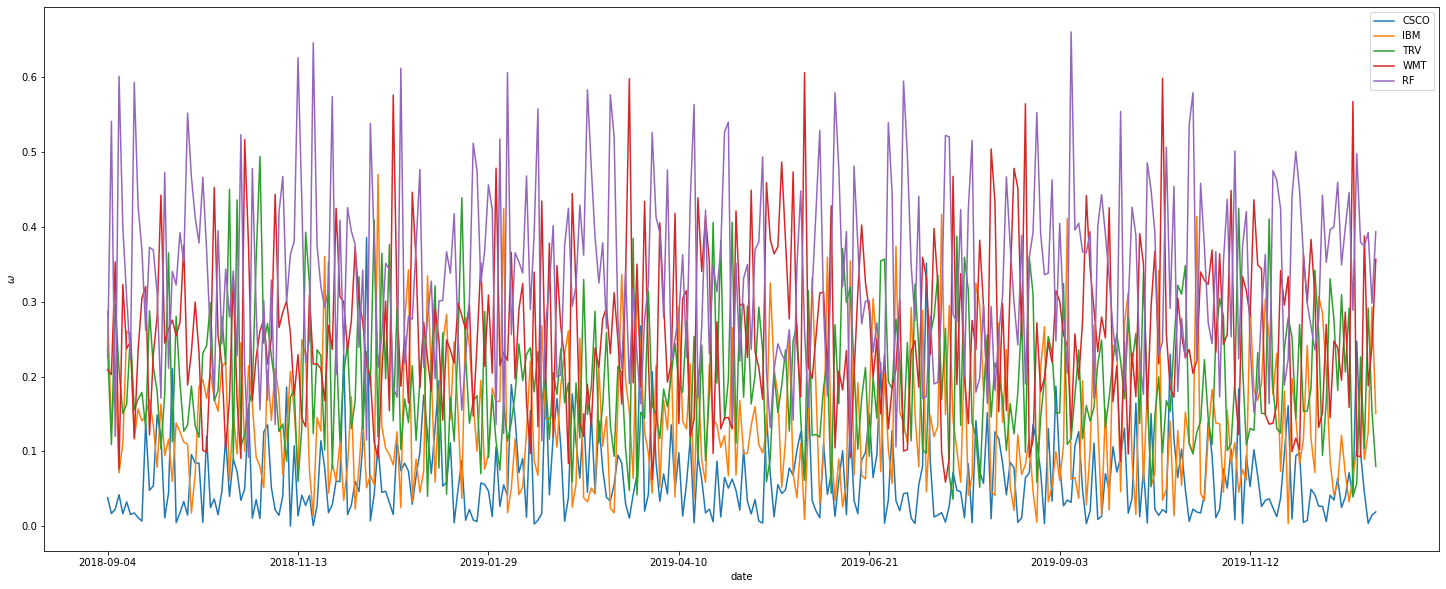

In [17]:
df_weights = pd.DataFrame(res, index=df_prices["2018-09-01":"2019-12-31"].index)
df_weights.plot.line(figsize=(25,10))
plt.ylabel("$\omega$")
plt.show()

In [15]:
df_weights.mean()

CSCO    0.065141
IBM     0.141772
TRV     0.196735
WMT     0.258954
RF      0.337404
dtype: float64